# Check SWU filled with ERA5-Land  

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

## Get data from Florent

In [3]:
path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5_Land'

In [20]:
df = pd.read_excel(path+'/SWupCorrMickael.xlsx', header=[0, 1, 2], parse_dates=[0], index_col=0)
df.index = pd.to_datetime(df.index, format='mixed')
df.index = df.index.round('H')
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df.columns = ['SWU_obs_valid', 'SWU_ERA5L', 'SWU_ERA5L_valid', 'albedo']
df

,SWU_obs_valid,SWU_ERA5L,SWU_ERA5L_valid,albedo
2013-07-11 09:00:00,50.587487,51.655972,51.655972,0.171599
2013-07-11 10:00:00,52.622368,69.043335,69.043335,0.166905
2013-07-11 11:00:00,86.071440,68.621246,68.621246,0.167350
2013-07-11 12:00:00,94.604393,92.516388,92.516388,0.167718
2013-07-11 13:00:00,71.596031,94.551804,94.551804,0.168557
...,...,...,...,...
2025-07-31 20:00:00,NaN,NaN,NaN,NaN
2025-07-31 21:00:00,NaN,NaN,NaN,NaN
2025-07-31 22:00:00,NaN,NaN,NaN,NaN
2025-07-31 23:00:00,NaN,NaN,NaN,NaN


In [39]:
ds = df.to_xarray()
ds = ds.rename({'index': 'time'})
ds

<xarray.Dataset> Size: 4MB
Dimensions:          (time: 105689)
Coordinates:
  * time             (time) datetime64[ns] 846kB 2013-07-11T09:00:00 ... 2025...
Data variables:
    SWU_obs_valid    (time) float64 846kB 50.59 52.62 86.07 94.6 ... nan nan nan
    SWU_ERA5L        (time) float64 846kB 51.66 69.04 68.62 ... nan nan nan
    SWU_ERA5L_valid  (time) float64 846kB 51.66 69.04 68.62 ... nan nan nan
    albedo           (time) float64 846kB 0.1716 0.1669 0.1673 ... nan nan nan

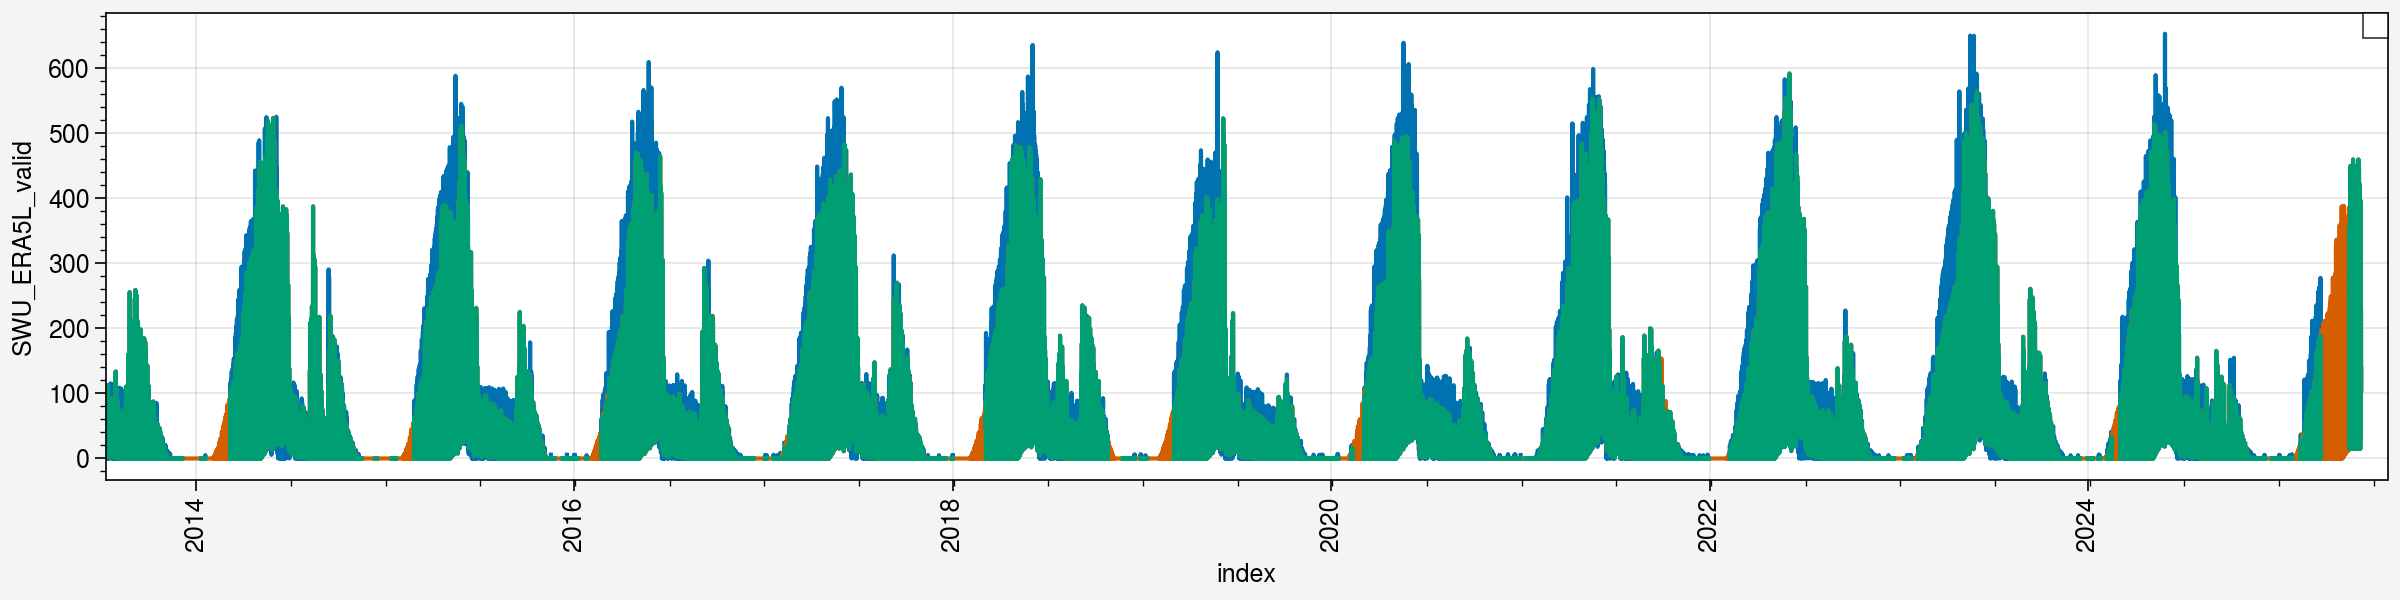

In [31]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(12,3))

# ds_interp_out_grid.plot(ax=axs[0])
ds.SWU_obs_valid.plot(ax=axs[0])
ds.SWU_ERA5L.plot(ax=axs[0])
ds.SWU_ERA5L_valid.plot(ax=axs[0])
axs.legend()

In [58]:
def SWU_pred0_func(SWU_ERA5, a, b):
    return SWU_ERA5 * a + b 

def SWU_pred1_func(SWU_ERA5, a):
    return SWU_ERA5 * a 

# def LWD_pred_func(LWD_ERA5, T_ERA5, a, b, c):
#     return LWD_ERA5 * a + T_ERA5 * b + c

def mse(x, y):
    return ((x - y)**2).mean().values.item(0)

In [61]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b= params # <-- for readability you may wish to assign names to the component variables
    metric = mse(
        ds.SWU_obs_valid.dropna(dim='time'),
        a*ds.SWU_ERA5L_valid.dropna(dim='time') + b
    )
    return metric

initial_guess = [1, 1]
result = optimize.minimize(f, initial_guess)
if result.success:
    fitted_params = result.x
    print('RMSE = {:0.3f}'.format(np.sqrt(result.fun)))
    print(fitted_params)
    print('R = {:0.3f}'.format(xr.corr(ds.SWU_obs_valid, ds.SWU_ERA5L_valid, dim='time')))
    print('R2 = {:0.3f}'.format(xr.corr(ds.SWU_obs_valid, ds.SWU_ERA5L_valid, dim='time')**2))
else:
    raise ValueError(result.message)

RMSE = 44.281
[1.03870926 2.01347644]
R = 0.920
R2 = 0.846


In [64]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a = params # <-- for readability you may wish to assign names to the component variables
    metric = mse(
        ds.SWU_obs_valid.dropna(dim='time'),
        a*ds.SWU_ERA5L_valid.dropna(dim='time')
    )
    return metric

initial_guess = [1]
result = optimize.minimize(f, initial_guess)
if result.success:
    fitted_params = result.x
    print('RMSE = {:0.4f}'.format(np.sqrt(result.fun)))
    print(fitted_params)
    print('R = {:0.4f}'.format(xr.corr(ds.SWU_obs_valid, ds.SWU_ERA5L_valid, dim='time')))
    print('R2 = {:0.4f}'.format(xr.corr(ds.SWU_obs_valid, ds.SWU_ERA5L_valid, dim='time')**2))
else:
    raise ValueError(result.message)

RMSE = 44.3137
[1.04778142]
R = 0.9197
R2 = 0.8459


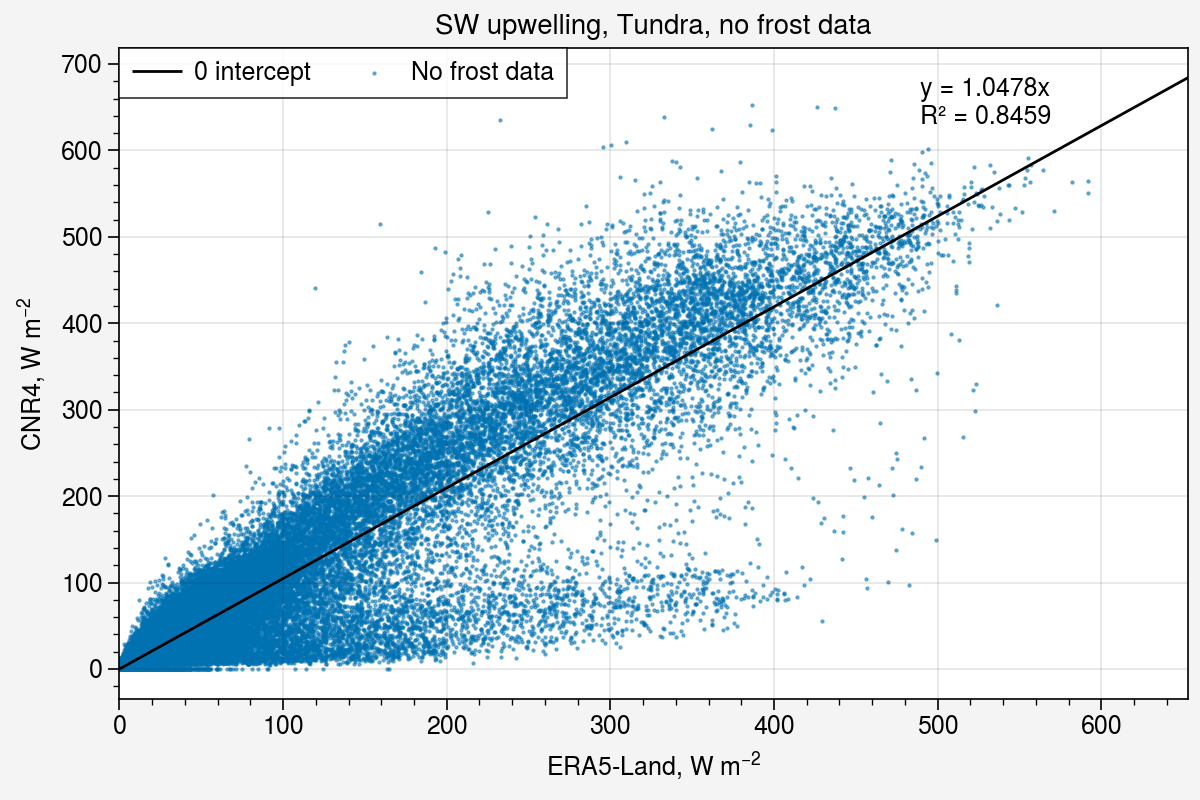

In [76]:
fig, ax = pplt.subplots(figsize=(6, 4))

# Nuage de points
ax.scatter(ds.SWU_ERA5L_valid, ds.SWU_obs_valid, markersize=1, alpha=0.5, label='No frost data')

# Droite de régression
x_line = np.linspace(0, ds.SWU_obs_valid.max(), 100)
slope = 1.04778142
ax.plot(x_line, slope * x_line, color='black', label='0 intercept', lw=1)

# Texte avec pente et R²
ax.format(
    xlabel='ERA5-Land, W m$^{-2}$',
    ylabel='CNR4, W m$^{-2}$',
    title='SW upwelling, Tundra, no frost data',
)

ax.text(
    0.75 * ds.SWU_obs_valid.max(), 1.05 * ds.SWU_obs_valid.max(),
    f'y = {slope:.4f}x\nR² = {0.8459}',
    ha='left', va='top'
)

ax.legend()
fig.save('CorrSWup_all.png')

In [78]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b= params # <-- for readability you may wish to assign names to the component variables
    metric = mse(
        ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).dropna(dim='time'),
        a*ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).dropna(dim='time') + b
    )
    return metric

initial_guess = [1, 1]
result = optimize.minimize(f, initial_guess)
if result.success:
    fitted_params = result.x
    print('RMSE = {:0.3f}'.format(np.sqrt(result.fun)))
    print(fitted_params)
    print('R = {:0.3f}'.format(xr.corr(
        ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), 
        ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), dim='time')))
    print('R2 = {:0.3f}'.format(xr.corr(
        ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), 
        ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), dim='time')**2))
else:
    raise ValueError(result.message)

RMSE = 22.283
[1.22790245 3.91209903]
R = 0.977
R2 = 0.955


In [83]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a = params # <-- for readability you may wish to assign names to the component variables
    metric = mse(
        ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).dropna(dim='time'),
        a*ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).dropna(dim='time')
    )
    return metric

initial_guess = [1.22]
result = optimize.minimize(f, initial_guess)
if result.success:
    fitted_params = result.x
    print('RMSE = {:0.4f}'.format(np.sqrt(result.fun)))
    print(fitted_params)
    print('R = {:0.4f}'.format(xr.corr(
        ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), 
        ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), dim='time')))
    print('R2 = {:0.4f}'.format(xr.corr(
        ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), 
        ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), dim='time')**2))
else:
    raise ValueError(result.message)

RMSE = 22.5516
[1.24702173]
R = 0.9774
R2 = 0.9553


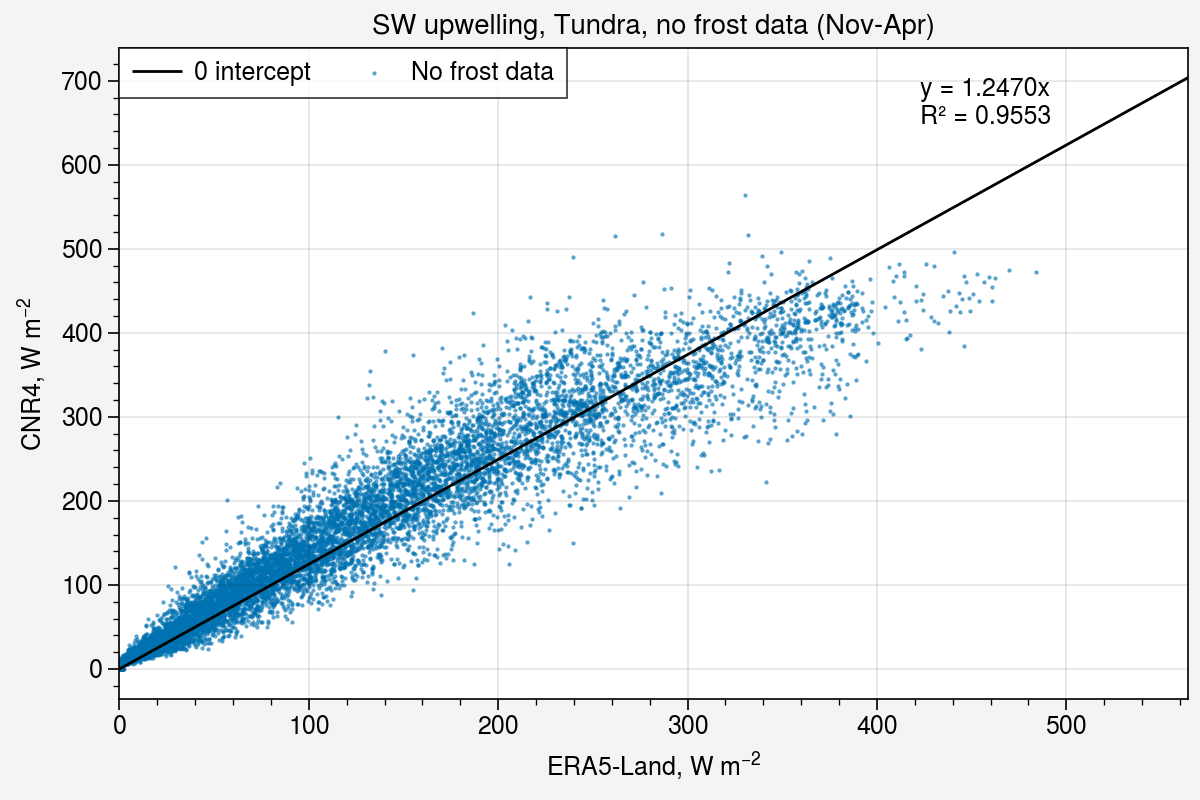

In [88]:
fig, ax = pplt.subplots(figsize=(6, 4))

# Nuage de points
ax.scatter(
    ds.SWU_ERA5L_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), 
    ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])), 
    markersize=1, alpha=0.5, label='No frost data')

# Droite de régression
x_line = np.linspace(0, ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).max(), 100)
slope = 1.24702173
ax.plot(x_line, slope * x_line, color='black', label='0 intercept', lw=1)

# Texte avec pente et R²
ax.format(
    xlabel='ERA5-Land, W m$^{-2}$',
    ylabel='CNR4, W m$^{-2}$',
    title='SW upwelling, Tundra, no frost data (Nov-Apr)',
)

ax.text(
    0.75 * ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).max(), 
    1.25 * ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4])).max(),
    f'y = {slope:.4f}x\nR² = {0.9553}',
    ha='left', va='top'
)

ax.legend()
fig.save('CorrSWup_Nov_Apr.png')

## Predictions

In [98]:
SWU_pred1 = SWU_pred1_func(ds.SWU_ERA5L, 1.24702173)
SWU_pred1

<xarray.DataArray 'SWU_ERA5L' (time: 105689)> Size: 846kB
array([64.41611898, 86.09853901, 85.57218532, ...,         nan,
               nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 846kB 2013-07-11T09:00:00 ... 2025-08-01

In [99]:
ds1 = ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4]))
ds2 = SWU_pred1.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4]))

### Check

In [100]:
ds1 = ds.SWU_obs_valid.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4]))
ds2 = SWU_pred1.where(ds.time.dt.month.isin([11, 12, 1, 2, 3, 4]))

print('RMSE = {:0.4f}'.format(np.sqrt(mse(ds1, ds2))))
print('R = {:0.4f}'.format(xr.corr(ds1, ds2, dim='time')))
print('R2 = {:0.4f}'.format(xr.corr(ds1, ds2, dim='time')**2))

RMSE = 22.5516
R = 0.9774
R2 = 0.9553


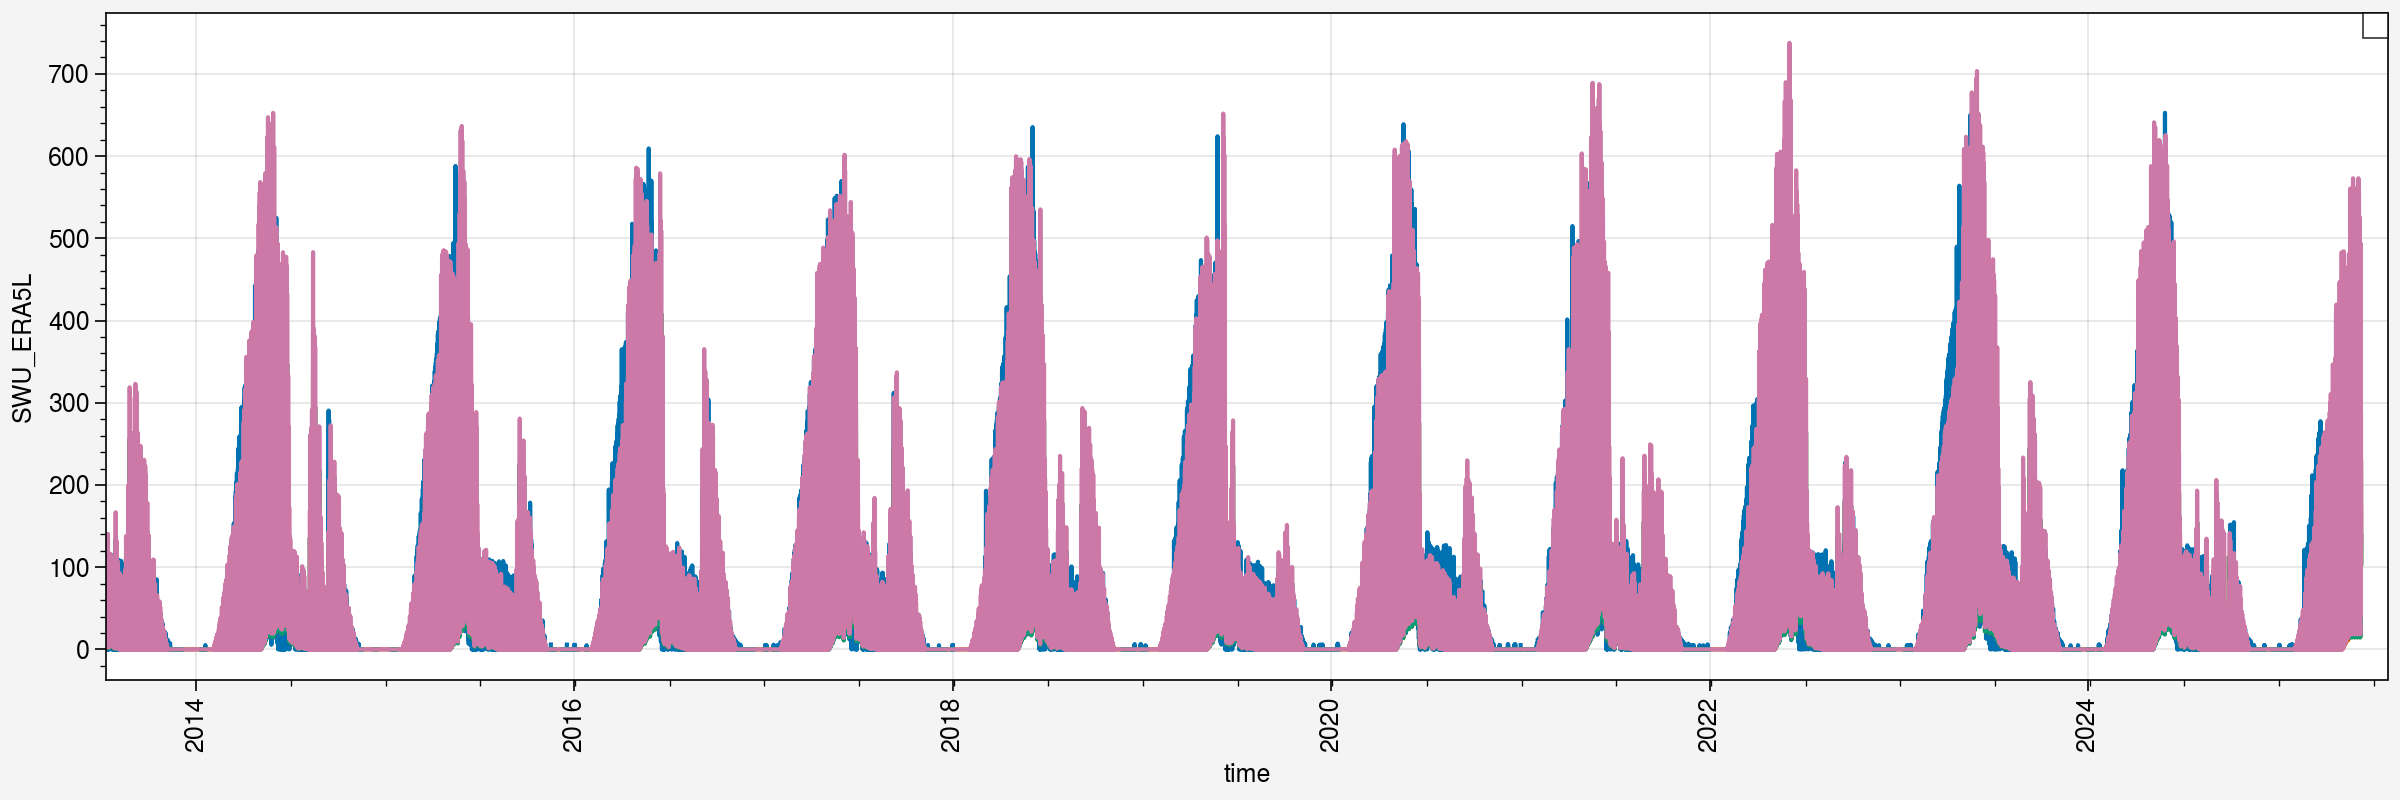

In [111]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(12,4))

# ds_interp_out_grid.plot(ax=axs[0])
ds.SWU_obs_valid.plot(ax=axs[0])
ds.SWU_ERA5L.plot(ax=axs[0])
ds.SWU_ERA5L_valid.plot(ax=axs[0])
SWU_pred1.plot(ax=axs[0])
axs.legend()

In [105]:
ds['SWU_ERA5L_corr'] = SWU_pred1
ds

<xarray.Dataset> Size: 5MB
Dimensions:          (time: 105689)
Coordinates:
  * time             (time) datetime64[ns] 846kB 2013-07-11T09:00:00 ... 2025...
Data variables:
    SWU_obs_valid    (time) float64 846kB 50.59 52.62 86.07 94.6 ... nan nan nan
    SWU_ERA5L        (time) float64 846kB 51.66 69.04 68.62 ... nan nan nan
    SWU_ERA5L_valid  (time) float64 846kB 51.66 69.04 68.62 ... nan nan nan
    albedo           (time) float64 846kB 0.1716 0.1669 0.1673 ... nan nan nan
    SWU_ERA5L_corr   (time) float64 846kB 64.42 86.1 85.57 115.4 ... nan nan nan

In [107]:
df_corr = ds.to_dataframe()
df_corr

,SWU_obs_valid,SWU_ERA5L,SWU_ERA5L_valid,albedo,SWU_ERA5L_corr
time,,,,,
2013-07-11 09:00:00,50.587487,51.655972,51.655972,0.171599,64.416119
2013-07-11 10:00:00,52.622368,69.043335,69.043335,0.166905,86.098539
2013-07-11 11:00:00,86.071440,68.621246,68.621246,0.167350,85.572185
2013-07-11 12:00:00,94.604393,92.516388,92.516388,0.167718,115.369946
2013-07-11 13:00:00,71.596031,94.551804,94.551804,0.168557,117.908154
...,...,...,...,...,...
2025-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN
2025-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN
2025-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN


In [109]:
df_corr.to_csv(path+'/ERA5_Land_h_SWU_corr_Nov_Apr_73.2N_80.05W_201307-202505_Bylot_loc_0005.csv')